# TUTORIAL: High-frequency template matching
Author: Jaime Pastor

The goal of this notebook is to explore the features named "highfreqtemplate", which consist of template matching in the higher range of the frequency of the spectrogram.

## PART 1: Non-extracted templates

The first thing that we should highlight is that the templates used to match are not extracted from other spectrograms but matrices of zeroes and ones.

The goal here is to detect any high-amplitude sound in the upper range of the frequencies.

In [99]:
# Set path to directory with folders train and test
path_data = '/Users/jaime/Documents/datasets/mlprojectdata/data/'
# Set path to code (where file "templateReduced.csv" is located)
code_data = '/Users/jaime/Google Drive/USF/MSAN_630_Advanced_ML/Project/moby/'

In [100]:
import numpy as np
import aifc
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib import mlab, cm
import pandas as pd
import cv2
%matplotlib inline

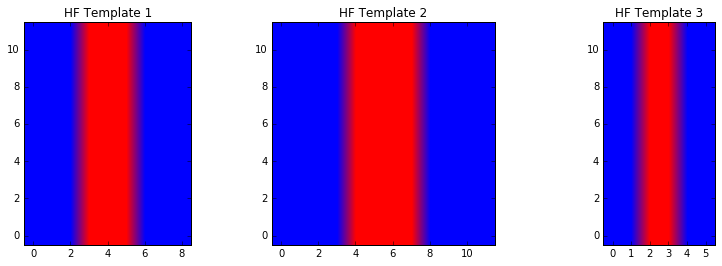

In [9]:
bar_ = np.zeros((12,9),dtype='Float32')
bar1_ = np.zeros((12,12),dtype='Float32')
bar2_ = np.zeros((12,6),dtype='Float32')
bar_[:,3:6] = 1.
bar1_[:,4:8] = 1.
bar2_[:,2:4] = 1.

fig = plt.figure(figsize = (14,4))
ax1 = plt.subplot(131)
plt.imshow(bar_, origin='lower', cmap = cm.get_cmap('bwr'))
plt.title('HF Template 1')
ax2 = plt.subplot(132)
plt.imshow(bar1_, origin='lower', cmap = cm.get_cmap('bwr'))
plt.title('HF Template 2')
ax3 = plt.subplot(133)
plt.imshow(bar2_, origin='lower',  cmap = cm.get_cmap('bwr'))
plt.title('HF Template 3')
plt.show()

As we can see above, the matrices of different dimensions represent spectrograms with a high-amplitude zone in the middle.

## PART 2: High-frequency range

The high-frequency range of each image is selected before matching with the above templates.
Note that high does not mean the upper range of the whole spectrogram, but the upper range of the subarea where whale calls are located. Let's see it visually:

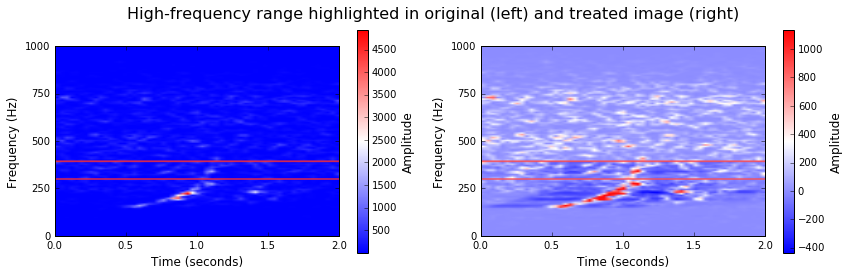

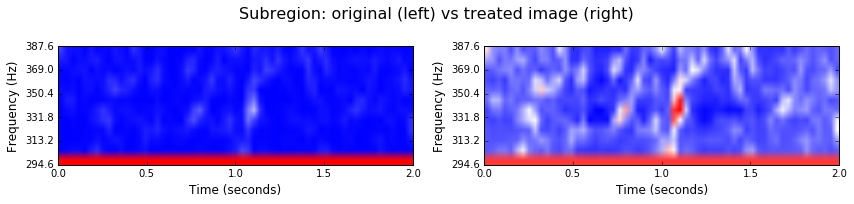

In [101]:
# ReadAIFF function
def ReadAIFF(file):
# Reads the frames from the audio clip and returns the uncompressed data
    s = aifc.open(file,'r')
    nFrames = s.getnframes()
    strSig = s.readframes(nFrames)
    return np.fromstring(strSig, np.short).byteswap()

def slidingWindowH(P,inner=3,outer=32,maxM=50,norm=True):
    Q = P.copy()
    m, n = Q.shape
    if norm:
        mval, sval = np.mean(Q[:maxM,:]), np.std(Q[:maxM,:])
        fact_ = 1.5
        Q[Q > mval + fact_*sval] = mval + fact_*sval
        Q[Q < mval - fact_*sval] = mval - fact_*sval
    wInner = np.ones(inner)
    wOuter = np.ones(outer)
    for i in range(maxM):
        Q[i,:] = Q[i,:] - (np.convolve(Q[i,:],wOuter,'same') - np.convolve(Q[i,:],wInner,'same'))/(outer - inner)
    return Q

# Function to allow code reusability
def plot_spectrogram(ax, P, y_axis, ex, cbar = True):
    im = plt.imshow(P, origin='lower', extent=ex, aspect=4, cmap = cm.get_cmap('bwr'))
    loc = plticker.MultipleLocator(base=3.0)
    ax.xaxis.set_major_locator(loc)
    ax.set_xticklabels(np.arange(-0.5,2.5,0.5))
    ax.set_yticklabels(y_axis)
    ax.set_xlabel('Time (seconds)', fontsize = 12)
    ax.set_ylabel('Frequency (Hz)', fontsize = 12)
    if cbar:
        cbar = plt.colorbar()
        cbar.set_label('Amplitude', fontsize = 12)

# Read one file as an example
params = {'NFFT':256, 'Fs':2000, 'noverlap':192} 
s = ReadAIFF(path_data + 'train/train6.aiff')
P, freqs, bins = mlab.specgram(s, **params)

# Pre-process the image
maxM = 50
Q = slidingWindowH(P,inner=7,maxM=50,norm=True)

# Subset
P2 = P[38:maxM,:]
Q2 = Q[38:maxM,:]

# Border in original image
P[38,:], P[maxM,:] = 4500, 4500
Q[38,:], Q[maxM,:] = 900, 900

# Plot original with border around selected area
fig = plt.figure(figsize = (14,4))
ax1 = plt.subplot(121)
plot_spectrogram(ax1, P, range(0,1001,250), [-6,6,-1,1])
ax2 = plt.subplot(122)
plot_spectrogram(ax2, Q, range(0,1001,250), [-6,6,-1,1])
plt.suptitle('High-frequency range highlighted in original (left) and treated image (right)', fontsize = 16)
plt.show()

# New yaxis limits
y_min2 = 38 / 129.0 * 1000
y_max2 = maxM / 129.0 * 1000
step = (y_max2 - y_min2)/ 5.0

# Plot selected area, to feed teplate matching
fig = plt.figure(figsize = (14,4))
ax1 = plt.subplot(121)
plot_spectrogram(ax1, P2, 
                 [round(x, 1) for x in np.arange(y_min2, y_max2 + step, step)],
                 [-6,6,0,1], False)
ax2 = plt.subplot(122)
plot_spectrogram(ax2, Q2, 
                 [round(x, 1) for x in np.arange(y_min2, y_max2 + step, step)], 
                 [-6,6,0,1], False)
plt.suptitle('Subregion: original (left) vs treated image (right)', fontsize = 16)
plt.subplots_adjust(top=1.15)
plt.show()

## PART 3: Template matching

Finally, each image is matched with the three templates, and the value corresponding to the best match is returned. Using the image from above example (we look for matches between the templates and the right bottom image above):

 Max_val= 0.29


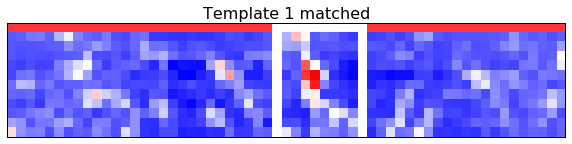

 Max_val= 0.28


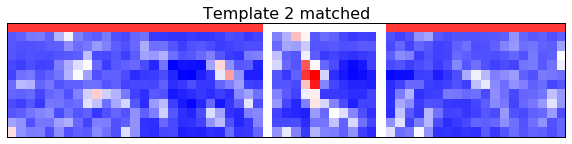

 Max_val= 0.36


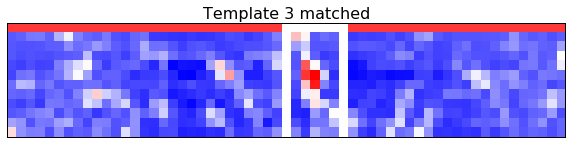

In [103]:
# Match template function
def match_template(template, P, temp_num):
    w, h = template.shape[::-1]
    Q = P.copy()
    # Set method 
    meth = 'cv2.TM_CCOEFF_NORMED'
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(Q,template,method)
    # Obtain vals and locs (max_lox corresponds to the best match)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    print ' Max_val= %.2f' % max_val
    # Add rectangle with match
    bottom_right = (max_loc[0] + w, max_loc[1] + h)
    cv2.rectangle(Q,max_loc, bottom_right, 400, 1)
    
    # Plot matching and image with best match in rectangle
    plt.figure(figsize = (10,6))
    plt.imshow(Q, cmap = cm.get_cmap('bwr'), interpolation='nearest')
    plt.title('Template %d matched' % temp_num, fontsize = 16), plt.xticks([]), plt.yticks([])
    plt.show()

# Match the three templates in the above seen subregion
match_template(bar_, Q2.astype('Float32'), 1)    
match_template(bar1_, Q2.astype('Float32'), 2)
match_template(bar2_, Q2.astype('Float32'), 3)

We can see the white rectangle showing the best match in the image, exactly where the whale call is located.